## Food vision mini

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras import layers 
import os 
import datetime 
from helpers import *  
import datetime

In [2]:
scenarios = [
    {
        "scnario": "scenario_0",
        "name": "model_0",
        "experiment_name": "ten_percent_101_food", 
        "data_augmentation": False, 
        "fine_tune": False
    },
    {
        "scnario": "scenario_1",
        "name": "model_1",
        "experiment_name": "ten_percent_101_food", 
        "data_augmentation": False, 
        "fine_tune": True
    }
]

scenarios_df = pd.DataFrame(scenarios) 
scenarios_df

,scnario,name,experiment_name,data_augmentation,fine_tune
0,scenario_0,model_0,ten_percent_101_food,False,False
1,scenario_1,model_1,ten_percent_101_food,False,True


In [3]:
!nvidia-smi

Tue Dec 23 22:15:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.44.01              Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              9W /   75W |     364MiB /  12227MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
walk_data_directory("data/101_food_classes_10_percent/")

There are 2 folders and 0 in 'data/101_food_classes_10_percent/'
There are 101 folders and 0 in 'data/101_food_classes_10_percent/test'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/apple_pie'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/baby_back_ribs'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/baklava'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beef_carpaccio'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beef_tartare'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beet_salad'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beignets'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/bibimbap'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/bread_pudding'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/breakfast_burrito'
There are 0 folders and 250 in '

In [5]:
ten_percent_101_food_train_dir = "data/101_food_classes_10_percent/train/"
ten_percent_101_food_test_dir = "data/101_food_classes_10_percent/test/" 

ten_percent_101_train_ds, ten_percent_101_test_ds = import_and_create_train_test_ds(train_dir=ten_percent_101_food_train_dir, 
                                                                                   test_dir=ten_percent_101_food_test_dir)  



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


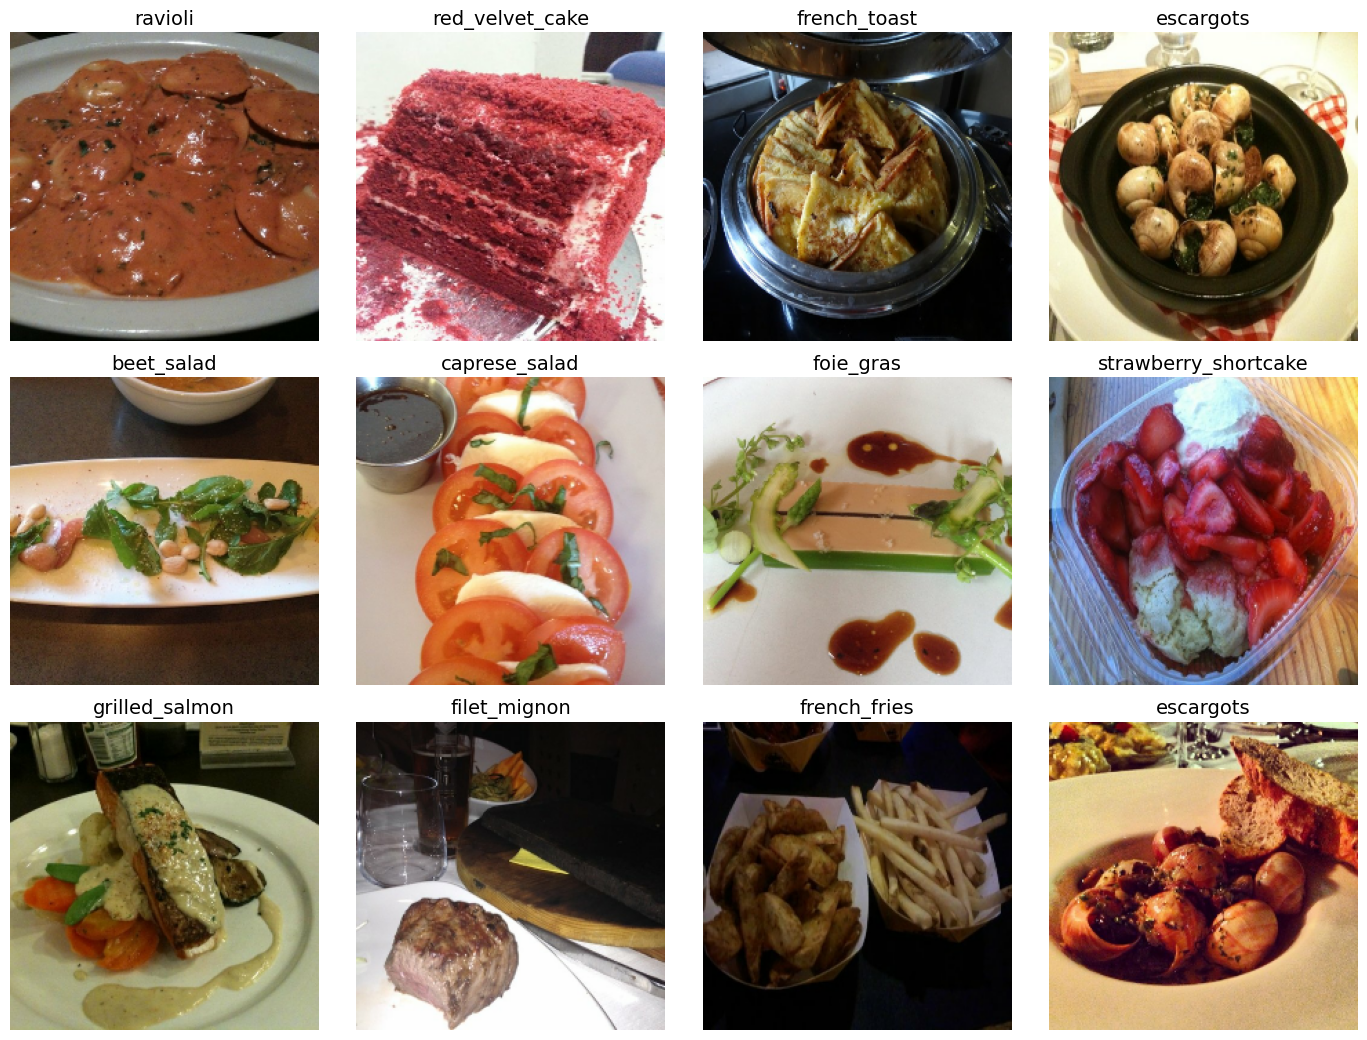

In [6]:
view_all_images_in_a_batch_ds(ten_percent_101_train_ds, max_images=12)

In [7]:
scenarios_df

,scnario,name,experiment_name,data_augmentation,fine_tune
0,scenario_0,model_0,ten_percent_101_food,False,False
1,scenario_1,model_1,ten_percent_101_food,False,True


# Train big dog model with transfer learning  

1. Create a ModelCheckpoint callback
2. Create a TensorBoard callback
3. Create a data augmentation layer
4. Build a headless (no top layers) Functional EfficientNetB0 backboned-model (We will create our own output layer)
5. Compile Model
6. Fite model (validate on 15% of the data)

In [8]:
# Create ModelCheckpoint Callback & TensorBoard Callback 

def create_model_checkpoint_callback(dir_name, experiment_name): 
    checkpoint_path = os.path.join(
        dir_name, 
        experiment_name, 
        "ckpt-epoch{epoch:02d}.weights.h5"
    )

    return keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        save_best_only=False, 
        save_weights_only=True, 
        save_freq='epoch'
    )

def create_tensorboard_callback(dir_name, experiment_name): 
    log_dir = os.path.join(
        dir_name,
        experiment_name,
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return keras.callbacks.TensorBoard(
        log_dir=log_dir
    )

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2), 
    layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                            width_factor=(-0.2, 0.2)), 
    layers.RandomBrightness(0.2), 
    layers.RandomContrast(0.2), 
    layers.RandomZoom(0.2)
], name="data_augmentation")

In [10]:
BATCH_SIZE = 32 
INPUT_SHAPE = (224, 224, 3) 
NUM_CLASS = len(ten_percent_101_test_ds.class_names) 

# 1. Create base model 

base_model = keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False 

# 2. Create inputs & outputs  
inputs = keras.Input(shape=INPUT_SHAPE, name="input_layer") 
x = data_augmentation(inputs) 
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x) 
x = layers.Dropout(0.2)(x) 
outputs = layers.Dense(NUM_CLASS, activation="softmax", name="output_layer")(x) 

# 3. Create model 
model_0 = keras.Model(inputs, outputs, name="ten_percent_101_food") 

# 4. Compile model 
model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(),  
    optimizer=keras.optimizers.Adam(), 
    metrics=["accuracy"]
)

model_0.summary()

Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
history_0 = model_0.fit(
    ten_percent_101_train_ds,
    validation_data=ten_percent_101_test_ds, 
    validation_steps=int(0.15 * (len(ten_percent_101_test_ds))) , 
    epochs=5, 
    callbacks=[
        create_tensorboard_callback(
            dir_name="logs/tensorboard",
            experiment_name= "ten_percent_101_food"
        ), 
        create_model_checkpoint_callback(
            dir_name="logs/model_checkpoints/", 
            experiment_name="ten_percent_101_food"
        )
    ], 
    verbose=2
)

Epoch 1/5
237/237 - 31s - 131ms/step - accuracy: 0.1480 - loss: 3.9095 - val_accuracy: 0.3414 - val_loss: 2.8909
Epoch 2/5
237/237 - 15s - 65ms/step - accuracy: 0.3145 - loss: 2.9996 - val_accuracy: 0.4277 - val_loss: 2.3786
Epoch 3/5
237/237 - 13s - 57ms/step - accuracy: 0.3695 - loss: 2.6722 - val_accuracy: 0.4648 - val_loss: 2.1935
Epoch 4/5
237/237 - 15s - 64ms/step - accuracy: 0.4144 - loss: 2.4633 - val_accuracy: 0.4838 - val_loss: 2.0512
Epoch 5/5
237/237 - 14s - 57ms/step - accuracy: 0.4342 - loss: 2.3174 - val_accuracy: 0.4944 - val_loss: 1.9987


In [12]:
results_scenario_0 = model_0.evaluate(ten_percent_101_test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.4990 - loss: 1.9814


In [13]:
results_scenario_0

[1.9864929914474487, 0.4966336488723755]

In [14]:
model_0.load_weights("logs/model_checkpoints/ten_percent_101_food/ckpt-epoch05.weights.h5") 

In [15]:
np.isclose(np.array(results_scenario_0), np.array(model_0.evaluate(ten_percent_101_test_ds)))

790/790 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.5002 - loss: 1.9776


array([ True,  True])

In [16]:
model_0.summary()

Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,716 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,764 (1010.80 KB)

In [17]:
## Prepare model for fine tuning  
model_0.layers[2].trainable = True 

for layer in model_0.layers[2].layers[:-10]: 
    layer.trainable = False
print(f"Number of trainable layers in base_model : {len(model_0.layers[2].trainable_variables)}")


model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=['accuracy']
)
for i, layer in enumerate(model_0.layers): 
    print(i, layer.name, layer.trainable)

Number of trainable layers in base_model : 10
0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2d True
4 dropout True
5 output_layer True


In [18]:
model_0.summary()

Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 1,022,613 (3.90 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [19]:
initial_epochs = 5 
epochs = 5 

history_1 = model_0.fit(
    ten_percent_101_train_ds,
    validation_data=ten_percent_101_test_ds, 
    validation_steps=int(0.15 * (len(ten_percent_101_test_ds))) , 
    callbacks=[
        create_tensorboard_callback(
            dir_name="logs/tensorboard",
            experiment_name= "ten_percent_101_food_fine"
        ), 
        create_model_checkpoint_callback(
            dir_name="logs/model_checkpoints/", 
            experiment_name="ten_percent_101_food_fine"
        )
    ],
    initial_epoch=initial_epochs,
    epochs=initial_epochs + 5, 
    verbose=2
)

Epoch 6/10
237/237 - 28s - 120ms/step - accuracy: 0.4737 - loss: 2.1590 - val_accuracy: 0.5336 - val_loss: 1.7543
Epoch 7/10
237/237 - 16s - 67ms/step - accuracy: 0.5380 - loss: 1.9163 - val_accuracy: 0.5538 - val_loss: 1.6740
Epoch 8/10
237/237 - 16s - 69ms/step - accuracy: 0.5493 - loss: 1.8191 - val_accuracy: 0.5686 - val_loss: 1.6113
Epoch 9/10
237/237 - 15s - 64ms/step - accuracy: 0.5667 - loss: 1.7295 - val_accuracy: 0.5736 - val_loss: 1.5767
Epoch 10/10
237/237 - 17s - 71ms/step - accuracy: 0.5797 - loss: 1.6763 - val_accuracy: 0.5781 - val_loss: 1.5657


In [20]:
results_scenario_1 = model_0.evaluate(ten_percent_101_test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.5891 - loss: 1.5396


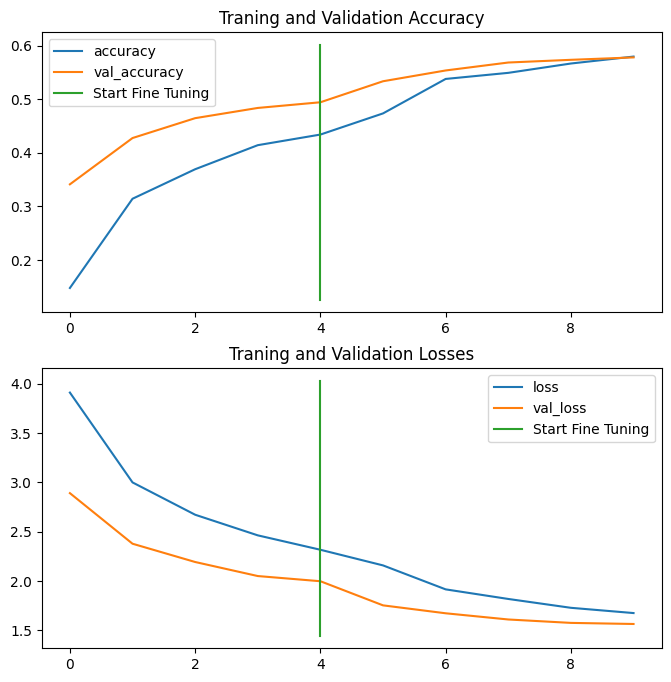

In [21]:
compare_history(original_history=history_0, 
               new_history=history_1)

In [28]:
keras.Model.save(model_0, "models/ten_percent_101_food_model.keras")

In [29]:
loaded_model = keras.models.load_model("models/ten_percent_101_food_model.keras")

In [ ]:
loaded_model_results = loaded_model.evaluate(ten_percent_101_test_ds)

In [ ]:
np.isclose(np.array(results_scenario_1), np.array(model_0.evaluate(loaded_model_results)))